<h1 align="center">EE596 - Homework 3 Report</h1>
<h4 align="center">Prepared by Paul Adams</h4>

\pagebreak

# Deliverables

##  Keypoints for the Capri image

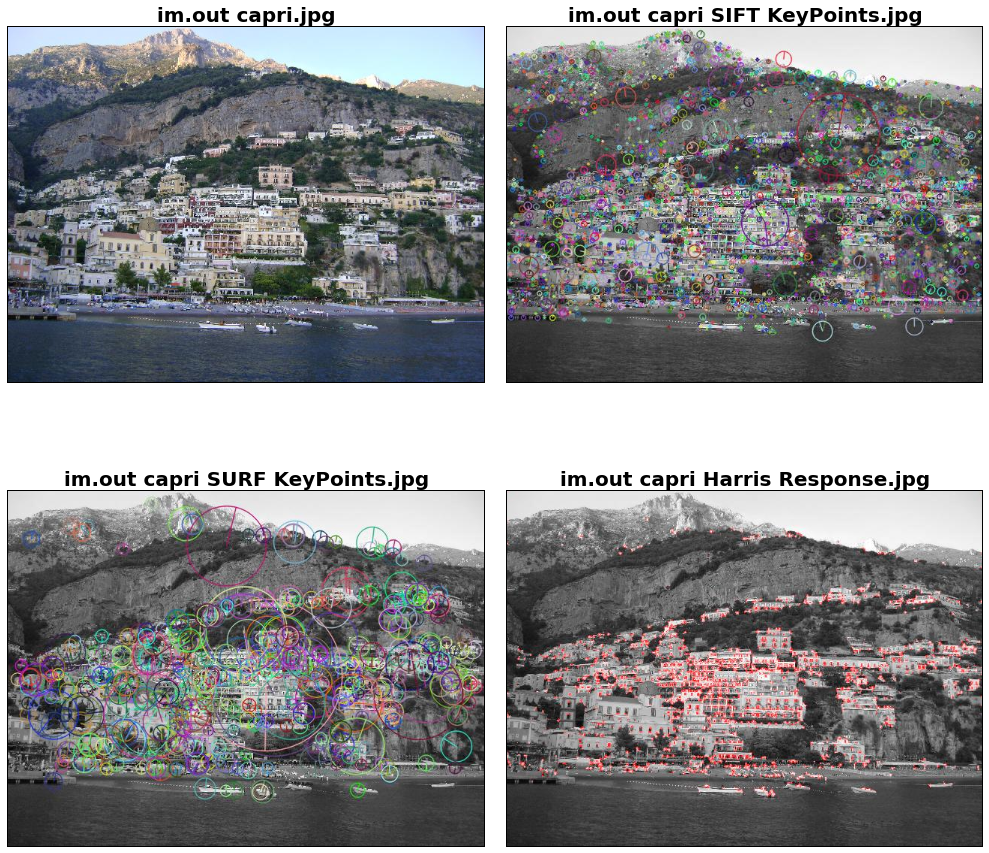

In [6]:
names = glob("im.out/capri*.jpg"); images = [imread(name) for name in names]; 
si.show(images, names, 4)

\pagebreak

## SURF KeyPoints for Image Pairs a, b

<h3 align="center">KeyPoint Values Table</h3>

| Image Name   |    angle |   class_id |   octave | pt                 |   response |   size |
|:-------------|---------:|-----------:|---------:|:-------------------|-----------:|-------:|
| b1.jpg       | 275.762  |          1 |        0 | (269.264, 323.189) |    3278.86 |     15 |
| b2.jpg       | 181.375  |          1 |        0 | (635.280, 266.039) |    2934    |     18 |
| a1.jpg       | 281.724  |          1 |        1 | (312.598, 254.270) |    4192.21 |     27 |
| a2.jpg       | 271.322  |         -1 |        1 | (471.772, 328.027) |    4726.04 |     54 |

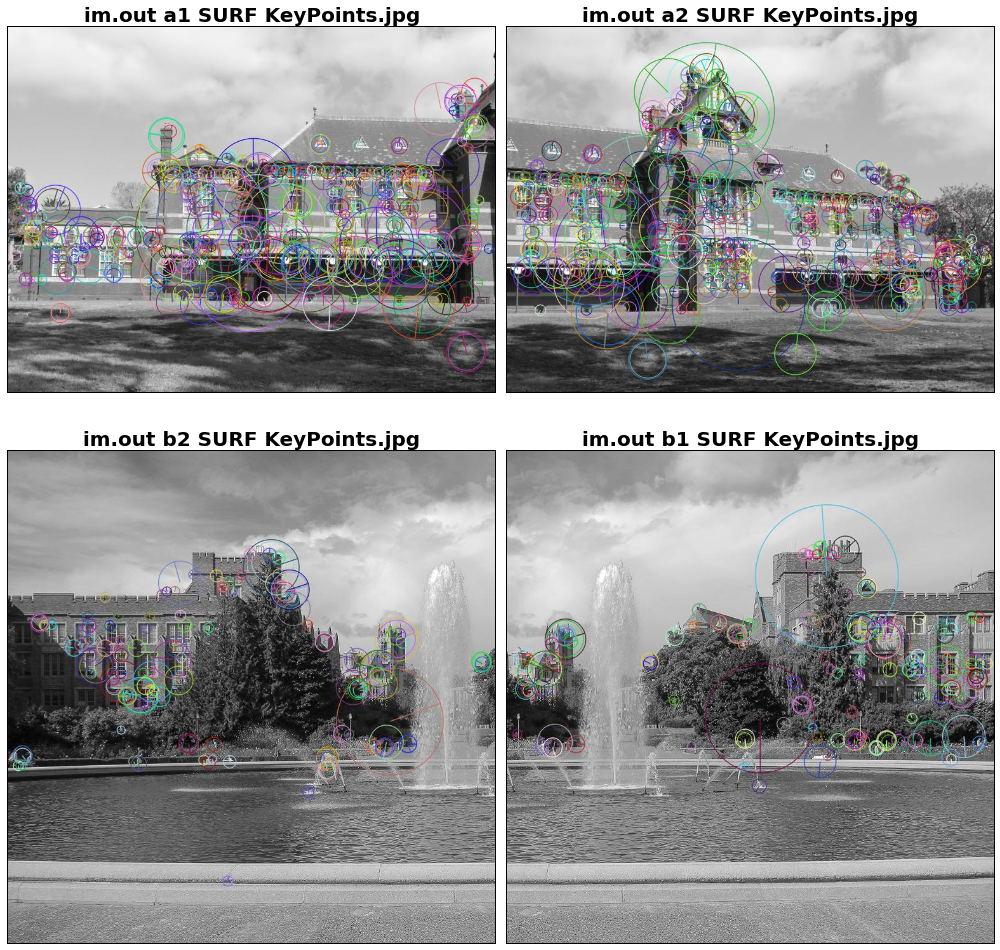

In [5]:
names = glob("im.out/a*SURF*.jpg"); names.extend(glob("im.out/b*SURF*.jpg"));
images = [imread(name) for name in names]; si.show(images, names, 4)

\pagebreak

##  Homographies and Mappings

| Homography   |    Image     |     a   |
|-------------:|-------------:|--------:| 
|  0.740279    |  0.0317422   | 501.333 |
| -0.120426    |  0.948447    |   4.885 |
| -0.000316812 | -3.77972e-06 |   1     |

| Homography   |    Image     |     b       |
|-------------:|-------------:|------------:|
|  0.999221    | -3.86644e-05 | -520.577    |
| -0.000391716 |  0.999287    |    0.301853 |
| -7.7908e-07  | -2.27897e-07 |    1        |

| Image Name   |   distance |   imgIdx |   queryIdx |   trainIdx |
|:-------------|-----------:|---------:|-----------:|-----------:|
| a1.jpg       |  0.297918  |        0 |          3 |          8 |
| a1.jpg       |  0.0347698 |        0 |          1 |          3 |
| a2.jpg       |  0.0395556 |        0 |          0 |          5 |
| a2.jpg       |  0.0613843 |        0 |          2 |          3 |
| a2.jpg       |  0.0156151 |        0 |          4 |          1 |
| b1.jpg       |  0.224355  |        0 |          1 |          6 |
| b1.jpg       |  0.227659  |        0 |          3 |        149 |
| b2.jpg       |  0.310168  |        0 |          0 |        569 |
| b2.jpg       |  0.237576  |        0 |          2 |       5259 |
| b2.jpg       |  0.31598   |        0 |          4 |        133 |

\pagebreak

##  Combined Warped Images

###  Image Set "a"

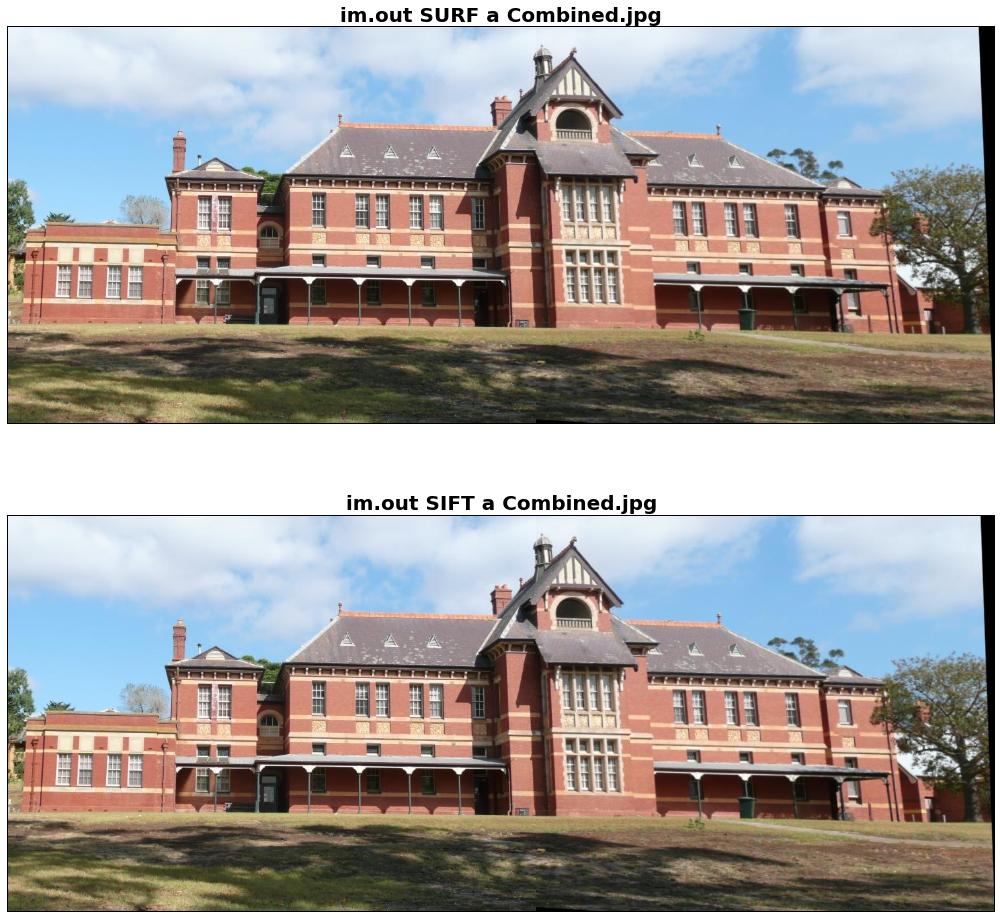

In [5]:
names = glob("im.out/*a*Combined*.jpg"); 
images = [imread(name) for name in names]; si.show(images, names, 2)

\pagebreak

###  Image Set "b"

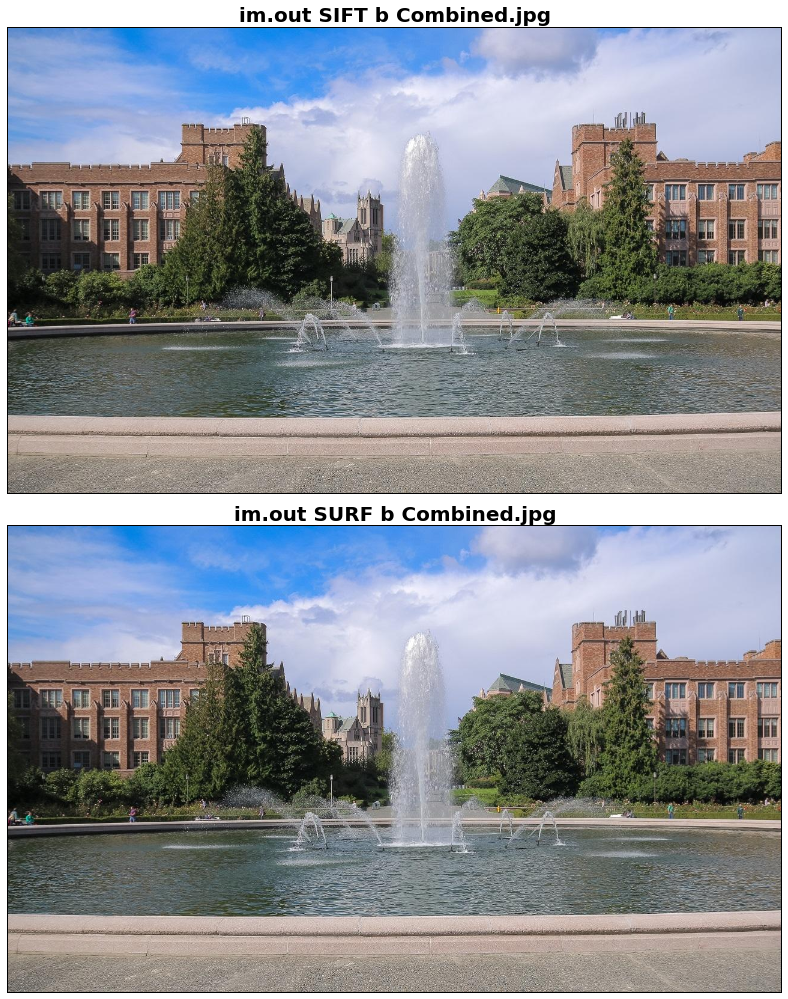

In [6]:
names = glob("im.out/*b*Combined*.jpg"); 
images = [imread(name) for name in names]; si.show(images, names, 2)

\pagebreak

# Brief Discussion of Results

##  Interest Operators


For the Harris response derivation, I used a method from sci-kit image's `feature` module called `corner_harris`. The results picked out the corners pretty well. 

For `SIFT` and `SURF` features however, only OpenCV had the needed routines. I discovered that the version of `OpenCV` I had built on my machine, version 3.0, was the first to compartmentalize developmental features and non-open-source features, of which SIFT, being patented, is included. This required downloading the `opencv_contrib` package from [https://github.com/itseez/opencv_contrib] and rebuilding the source with the appropriate flags. Fortunately, these extra steps made other features available, such as keypoint drawing. 

## Matching Descriptors and Computing Homography

In trying to implement the `FLANN` based matcher, I encountered another quirk of `OpenCV 3.0`. The matcher repeatedly encountered a strange error, even following the tutorial verbatim. After searching, I found this  [http://stackoverflow.com/questions/32931856/cv2-3-0-0-cv2-flannbasedmatcher-flann-knnmatch-is-throwing-cv2-error] related issue on StackOverflow. Rather than trying to rebuild the source again, I found the brute force, BFMatcher and used that with success. 

## Warping and Combining

The only challenge associated with the third part of the homework was getting the images in the right order so that the matching would find adjacent points. Also, since there was an overlap region, making the new image twice the width of the original left some zero columns on the right side of the new images. I added some code that found the zero columns and removed them from the image. 

I found equal success with both `SURF` and `SIFT` operators, not finding any visual difference between the two versions of stitched images. 

\pagebreak

# Python Code Listing

In [4]:
%matplotlib inline
from glob import glob
from matplotlib.pyplot import imread
sys.path.append('/home/adamspr/ee596/MachineVision')
from ScreenImage import ScreenImage
si = ScreenImage()

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import matplotlib
matplotlib.use("Qt4Agg")
from skimage.feature import corner_harris
from skimage.color import rgb2gray
from skimage.io import imread, imsave
from skimage.io import ImageCollection
from skimage import img_as_ubyte
from os.path import splitext, split
from glob import glob
import numpy as np
import cv2
from tabulate import tabulate
import pickle


def interest_operators(im, prefix):
    w, h = im.shape
    # Harris Response
    H = corner_harris(im)
    im_harr = np.tile(im[:, :, np.newaxis], (1, 1, 3))
    im_harr[H > np.mean(H) + 0.8*np.std(H), 0] = 255

    # SURF features
    min_hessian = 4000
    surf = cv2.xfeatures2d.SURF_create(min_hessian)
    kp, des = surf.detectAndCompute(im, None)
    im_surf = np.zeros((w, h, 3), np.uint8)
    cv2.drawKeypoints(im, kp, im_surf,
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # SIFT features
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(im, None)
    im_sift = img_as_ubyte(np.zeros((w, h, 3)))
    cv2.drawKeypoints(im, kp, im_sift,
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Write Out Results
    imsave("im.out/" + prefix + "_Harris_Response.jpg", im_harr)
    imsave("im.out/" + prefix + "_SIFT_KeyPoints.jpg", im_sift)
    imsave("im.out/" + prefix + "_SURF_KeyPoints.jpg", im_surf)


def homographize(ic, operator=None):
    bf = cv2.BFMatcher()

    if operator == "SURF":
        min_hessian = 400
        ops = cv2.xfeatures2d.SURF_create()
    elif operator == "SIFT":
        ops = cv2.xfeatures2d.SIFT_create()

    kpt0, des0 = ops.detectAndCompute(ic[1], None)
    kpt1, des1 = ops.detectAndCompute(ic[0], None)

    matches = bf.knnMatch(des0, des1, k=2)
    mp0 = np.array([kpt0[match[0].queryIdx].pt for match in matches])
    mp1 = np.array([kpt1[match[0].trainIdx].pt for match in matches])
    H, _ = cv2.findHomography(mp0, mp1, cv2.RANSAC)

    if operator == "SURF":
        tablex = []
        tabley = []
        # import ipdb; ipdb.set_trace()

        for i in range(5):
            y = matches[i][0]
            if i % 2:
                x = kpt0[np.random.random_integers(1000)]
                fn = ic.files[0].replace("im.in/", "")
            else:
                x = kpt1[np.random.random_integers(1000)]
                fn = ic.files[1].replace("im.in/", "")
            if i == 0:
                headerx = [name for name in dir(x) if not name.startswith('__')]
                headery = [name for name in dir(y) if not name.startswith('__')]
            valsx = [getattr(x, name) for name in headerx]
            valsy = [getattr(y, name) for name in headery]
            valsx.insert(0, fn); valsy.insert(0, fn)
            tablex.append(valsx); tabley.append(valsy)

        with open(fn[0] + "_homog_cache", "w+") as file_:
            file_.write(tabulate(H, tablefmt="pipe"))

        if fn[0] == "a":
            pickle.dump(tablex, open("xtable_cache", "w"))
            pickle.dump(tabley, open("ytable_cache", "w"))
        else:
            with open("_SURF_Map_table", "w+") as file_:
                atable = pickle.load(open("ytable_cache", "r"))
                [tabley.append(val) for val in atable]
                headery.insert(0, "Image Name")
                file_.write(tabulate(tabley, headery, tablefmt="pipe"))
            with open("_SURF_KeyPoints_table", "w+") as file_:
                atable = pickle.load(open("xtable_cache", "r"))
                [tablex.append(val) for val in atable]
                headerx.insert(0, "Image Name")
                file_.write(tabulate(tablex, headerx, tablefmt="pipe"))
    return H


def warp_and_stitch(homog, prefix):
    im = [imread(fn) for fn in (glob("im.in/" + prefix + "*.jpg"))]
    (h, w, d) = im[0].shape
    warped = cv2.warpPerspective(im[0], homog, (2*w, h))
    warped[0:h, 0:w, :] = im[1]
    x = np.sum(np.sum(warped, axis=2), axis=0)
    edge_idx = np.where(x == 0)[0][0]
    return warped[:, :edge_idx, :]


def imread_wrapper(fname):
    # for hw3, reads an image, converts to gray as uint8
    return img_as_ubyte(rgb2gray(imread(fname)))


def main():
    ic = ImageCollection("im.in/*.jpg", load_func=imread_wrapper)
    for i, im in enumerate(ic):
        prefix = splitext(split(ic.files[i])[1])[0]
        print "%s: Interest Operators..." % (prefix)
        interest_operators(im, prefix)

    for op in ["SURF", "SIFT"]:
        for prefix in ["a", "b"]:
            print "%s: %s: Matching Descriptors and Computing"\
                " Homography..." % (op, prefix)
            ic = ImageCollection("im.in/" + prefix + "*.jpg", load_func=imread_wrapper)
            H = homographize(ic, operator=op)
            print "%s: %s: Warp, Combine, Save..." % (op, prefix)
            stitched = warp_and_stitch(H, prefix)
            imsave("im.out/" + op + "_" + prefix + "_Combined.jpg", stitched)


if __name__ == '__main__':
    main()